In [2]:
import numpy as np

from scipy.linalg import norm
from scipy.sparse.linalg import spsolve, eigsh
from scipy.sparse import diags, csr_matrix
import scipy.stats
from scipy.signal import unit_impulse

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression

import re

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

In [3]:
# 1.1 

# Return right hand side of system Ty=f as np.array
def get_RHS(fvec, alpha, beta, dx):

    return np.append(np.append([dx**2 * fvec[0] - alpha], dx**2 * fvec[1:-1]) , [dx**2 * fvec[-1] - beta])


# Return sparse NxN Toeplitz matrix. Pure Toeplitz for Dirichlet conditions; modified for Neumann
def sparse_Toeplitz(N, condition='Dirichlet'):
    if condition == 'Neumann':
        return csr_matrix(diags([np.append(-2*np.ones(N-1), -1), np.ones(N-1), np.ones(N-1)], [0, 1, -1]))
    return csr_matrix(diags([-2*np.ones(N), np.ones(N-1), np.ones(N-1)], [0, 1, -1]))


# Return solution to two point boundary value problem y''=f
def twopBVP(fvec, alpha, beta, L, N):
    dx = L/(N+1) 
    
    return spsolve(sparse_Toeplitz(N), get_RHS(fvec, alpha, beta, dx))


# Return global error in RMS norm: recall that rms norm is RMS-norm= sqrt(dx)*2-norm
def get_error(exact_sol, num_sol, dx):
   
    return dx * norm(num_sol - exact_sol, ord=2)**2


# Return inner grid x, full grid x_full and finer full grid x_full_fine 
def get_grids(L, N, dx):
    x = np.linspace(dx, L-dx, N)
    
    return x, np.insert(x, [0, len(x)], [0, L]), np.linspace(0, L, 10000)


# Insert boundary values alpha, beta in first and last places of 
# solution vector sol (shape (N,)), respectively
def insert_boundary(sol, alpha, beta):
    
    return np.insert(sol, [0, len(sol)], [alpha, beta])


# Insert boundary values u0, uL(=u_N if Neumann condition) to 
# np.ndarray eigvects (shape (N, k)). Return eigenvector of shape (k, N+2).
def insert_boundary_eig(eigvects, N, k, u0=0, uL=0, condition='Dirichlet'):
    eigvects_new = np.ndarray((k,N+2))
        
    for i in range(len(eigvects.T)):
        if condition == 'Neumann': 
            uL = eigvects.T[i][-1]
        eigvects_new[i] = np.insert(eigvects.T[i], [0, N], [u0, uL])
    
    return eigvects_new

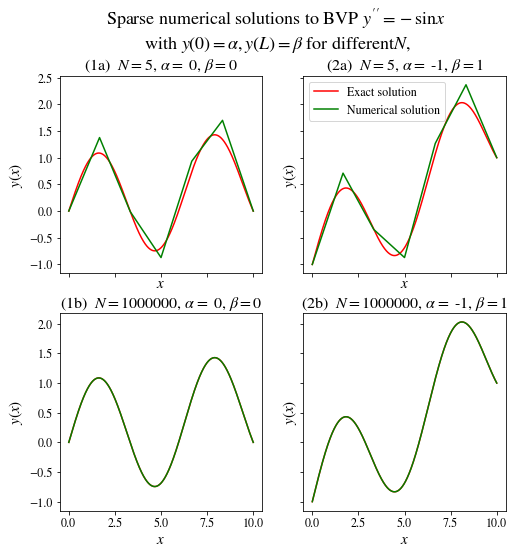

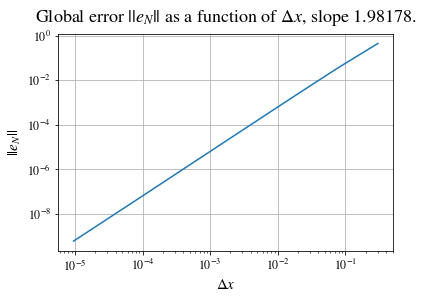

In [31]:
#1.1 

# Initialize constants
alphas = [0, -1]
betas = [0, 1]
L = 10
N = [5, 1000000]
labels = ['a', 'b']

# Prepare for plotting
fig1, axs = plt.subplots(len(alphas), len(N), figsize=[8, 8], 
                         sharey='row', sharex='col')
fig1.suptitle('Sparse numerical solutions to BVP $y^{\prime\prime}=-\sin{x}$' + 
              '\n with $y(0)$' + r'$=\alpha, y(L)=\beta$ for different' + 
              '$N, \alpha, \beta.$', fontsize=18, y=1)

# Iterate over different N, alpha, beta
for i in range(len(alphas)):
    for j in range(len(N)):
        dx = L/(N[j]+1)

        # Initialize grids and function f
        x, x_full, x_full_fine = get_grids(L, N[j], dx)
        f = -np.sin(x)

        # Get solutions on full intervals (insert boundary values)
        exact_sol = np.sin(x_full_fine) + x_full_fine*(betas[i]-alphas[i]-np.sin(L))/L + alphas[i]
        num_sol = insert_boundary(twopBVP(f, alphas[i], betas[i], L, N[j]), alphas[i], betas[i])

        # Plot solutions
        axs[j, i].plot(x_full_fine, exact_sol, label='Exact solution', color='r')
        axs[j, i].plot(x_full, num_sol, label='Numerical solution', color='g')
        axs[j, i].set_xlabel('$x$', fontsize=15)
        axs[j, i].set_ylabel('$y(x)$', fontsize=15)
        axs[j, i].set_title(f'({i+1}{labels[j]})  $N={N[j]}$,' + r' $\alpha =$' + 
                            f' {alphas[i]},' + r' $\beta$' + f'$={betas[i]}$', fontsize=16)
        if i and j == 0:
            axs[j, i].legend(fontsize=12);


### Solve and calculate global error for 32 < N < 1e6
# Initialize constants
Ns = [2**n for n in np.linspace(20, 5, 8, dtype='int')]
alpha = 0
beta = 0
dxs = [L/(n+1) for n in Ns]
errors = []

# Solve equation and calculate error for different N 
for n in Ns:
    x = np.linspace(0, L, n)
    f = -np.sin(x)
    exact_sol = np.sin(x) + x*(beta-alpha-np.sin(L))/L + alpha
    
    errors.append(get_error(exact_sol, twopBVP(f, alpha, beta, L, n), L/(n+1)))
    
# Calculate slope in loglog plot
clf = LinearRegression(n_jobs=-1).fit(np.log(dxs).reshape(-1,1), np.log(errors).reshape(-1,1))

fig2, ax5 = plt.subplots(1)

# Plot global error
ax5.loglog(dxs, errors)
ax5.set_xlabel('$\Delta x$', fontsize=15)
ax5.set_ylabel('$\|\|e_N\|\|$', fontsize=15)
ax5.set_title(f'Global error $\|\|e_N\|\|$ as a function of $\Delta x$, ' + 
              f'slope {clf.coef_[0][0]:.6}.', fontsize=18, y=1.025)
ax5.grid()

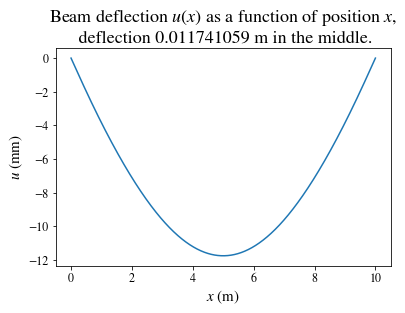

In [26]:
## 1.2

# Initialize constants
u0 = 0
uL = 0
M0 = 0
ML = 0

E = 1.9e11
q = -50e3

L = 10
N = 999

dx = L/(N+1)

# Construct inner and full grid
x, x_full, _ = get_grids(L, N, dx)

# Solve M'' = q
q_vec = q*np.ones(N)
M = twopBVP(q_vec, M0, ML, L, N)

# Prepare RHS F := M / EI(x)
I = 10**-3 * (3 - 2*np.cos(np.pi*x/L)**12)
F = 1/E * np.array([M[i]/I[i] for i in range(len(M))])

#  Solve u'' = F(x) and insert boundary values
u = insert_boundary(twopBVP(F, u0, uL, L, N), u0, uL)

# Plot solution
plt.plot(x_full, u*10**3)
plt.title(f'Beam deflection $u(x)$ as a function of position $x$, ' + 
          '\n deflection {np.abs(u[int(len(u)/2)]):.8} m in the middle.', fontsize=18)
plt.ylabel('$u$ (mm)', fontsize=15)
plt.xlabel('$x$ (m)', fontsize=15);

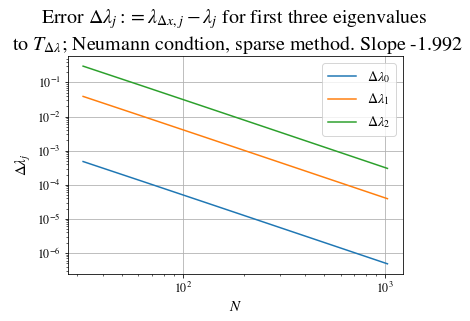

In [32]:
# 2.10

# Initialize constants (return k eigenvalues and eigenvectors)
L = 1
Ns = [2**n for n in range(5, 11)]
k = 3
u0 = 0

# Exact eigenvalues
eigvals_exact = [-(np.pi/2 + m*np.pi)**2 for m in range(k)]

# Construct list of array of differences lambda_dx - lambda, corresponding to different N
eigvals_diff = np.zeros(k)

# Calculate eigenvalues of T_dx for different number of steps N; return eigenvalue error.
for N in Ns: 
    dx = L/(N+1/2)
    eigvals, _ = eigsh(1/dx**2 * sparse_Toeplitz(N, condition='Neumann'), k, which='SM')
    
    # Calculate eigenvalue error
    eigvals_diff = np.vstack([eigvals_diff, eigvals_exact - np.flip(eigvals)])
        
# Remove first 
eigvals_diff = np.delete(eigvals_diff, 0, 0).T

# Calculate slope of loglog plot
clf = LinearRegression(n_jobs=-1).fit(np.log(Ns).reshape(-1,1), 
                                      np.log(np.abs(eigvals_diff[0])).reshape(-1,1))

# Plot results
plt.loglog(Ns, np.abs(eigvals_diff[0]), label='$\Delta \lambda_0$')
plt.loglog(Ns, np.abs(eigvals_diff[1]), label='$\Delta \lambda_1$')
plt.loglog(Ns, np.abs(eigvals_diff[2]), label='$\Delta \lambda_2$')
plt.title('Error $\Delta \lambda_j := \lambda_{\Delta x, j} - \lambda_j$ for first three ' + 
          'eigenvalues \n to $T_{\Delta \lambda}$; Neumann condtion, sparse method. ' + 
          f'Slope {clf.coef_[0][0]:.4}', fontsize=20)
plt.xlabel('$N$', fontsize=15)
plt.ylabel('$\Delta \lambda_j$', fontsize=15)
plt.legend(fontsize=14)
plt.grid()

In [273]:
2.11
# Choose specific number of steps N
N = 499

# Calculate eigenvalues of T_dx
dx = L/(N+1/2)
eigvals, _ = eigsh(1/dx**2 * sparse_Toeplitz(N, condition='Neumann'), k, which='SM')

for eigval in np.flip(eigvals):
    print(f'{eigval:.9}')

-2.46739907
-22.2064452
-61.6837566


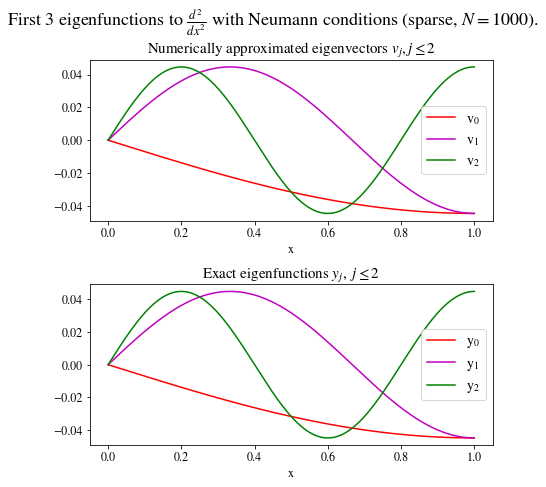

In [757]:
## 2.12

# Initialize constants 
N = 1000
L = 1
k = 3
u0 = 0
condition = 'Neumann'

# Define new grid with N inner points and x_N + dx/2 = 1. 
dx = L/(N+1/2)
x, x_full, _ = get_grids(L, N, dx)

# Calculate eigenvectors
_, eigvects = eigsh(1/dx**2 * sparse_Toeplitz(N, condition='Neumann'), k, which='SM')

# Insert boundary values u0, uL=(yN + yN+1)/2=yN (Neumann) into eigenvects
eigvects = insert_boundary_eig(eigvects, N, k, u0, condition=condition)

# Plot numerical and exact eigenvectors
fig1, (ax1, ax2) = plt.subplots(2, figsize=[6.4, 6.4], tight_layout=True)
colors = ['r', 'm', 'g']

for i in range(k):
    ax1.plot(x_full, eigvects[k-(i+1)], label=r'$\mathrm{v}$' +  f'$_{i}$', color=colors[i])
    ax2.plot(x_full, max(eigvects[k-(i+1)], key=abs)*np.sin((np.pi/2 + i*np.pi)*x_full), label=r'$\mathrm{y}$' +  f'$_{i}$', color=colors[i])
fig1.suptitle(f'First {k}' + r' eigenfunctions to $\frac{d^2}{dx^2}$ with Neumann conditions' + f' (sparse, $N={N}$).', fontsize=18, y=1.05)
ax1.set_title('Numerically approximated eigenvectors $v_j, j \leq 2$', fontsize=15)
ax2.set_title('Exact eigenfunctions $y_j, \ j \leq 2$', fontsize=15)
ax1.set_xlabel('x', fontsize=12)
ax2.set_xlabel('x', fontsize=12)
ax1.legend(fontsize=14)
ax2.legend(fontsize=14);

In [28]:
# Return sparse Hamilton operator
def sparse_hamilton(N, V, dx):
    return csr_matrix(sparse_Toeplitz(N) - diags(dx**2*V, 0))
    #return csr_matrix(diags([dx**2*V - 2*np.ones(N), np.ones(N-1), np.ones(N-1)], [0, 1, -1]))

# Return potential on inner grid [dx, L-dx], 
# keyword kw, number of grid points N, step size dx
def get_potential(kw, N, dx):
    L = dx*(N+1)
    x = np.linspace(dx, L-dx, N)
    
    if kw == 'x':
        return 1000*x, '$\ $linear potential'
    elif kw == 'ho':
        return 1000*x*(x-L), '$\ $quantum harmonic oscillator'
    elif kw == 'dwell':
        return np.piecewise(x, [x<2/5*L, np.logical_and(2/5*L<= x, x <= 3/5*L), x>3/5*L], [0, 850, 0]), 
                            '$\ $double infinite well'
    elif kw.endswith('wells'):
        n = int(re.search(r'\d+', kw).group())
        return get_nwells(n), '$\ $' + f'$n$={n}-well'
    elif kw == 'halfwell':
        return np.piecewise(x, [x<L/2, x>=L/2], [0, 1e3]), '$\ $half infinite well'
    elif kw == 'gauss':
        return 100*scipy.stats.norm.pdf(x, L/2, L/20)/np.mean(norm.pdf(x, L/2, L/10)), '$\ $Gaussian potential'
    elif kw == 'dirac':
        return 1000000*unit_impulse(N,'mid'), '$\ $centered Dirac potential'
    elif kw == 'triangle':
        return 3000*(1/2-np.abs(x-1/2)), '$\ $centered triangular potential'
    elif kw == 'sin2':
        return 800*np.sin(np.pi*x)**2, '$\ $sinusoidal potential'
    
    return np.zeros(N), 'n infinite well'

# Return float to scale amplitude of solution used in normalization process 
def get_norm_amp(kw):
    if kw == 'triangle':
        return 0.2
    elif kw == 'sin2':
        return 0.27
    elif kw.endswith('wells') and int(re.search(r'\d+', kw).group()) > 3:
        n = int(re.search(r'\d+', kw).group())
        if n < 10:
            return 0.5-0.025*n
        return 0.01
    return 1

def get_nwells(n):
        # Constants
        tot_width = 2*L/5
        splitting = L/n

        centers = [m*splitting for m in range(1,n)]
        width = tot_width/(n-1)

        return np.array([1e3 if i else 0 for i in np.logical_or.reduce(
            ([np.logical_and(center-width/2<x, x<center+width/2) for center in centers]))])

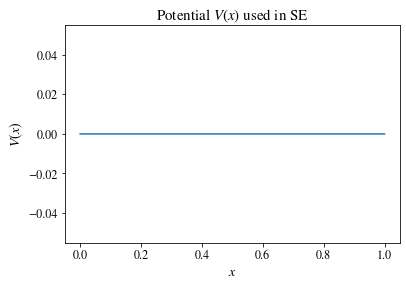

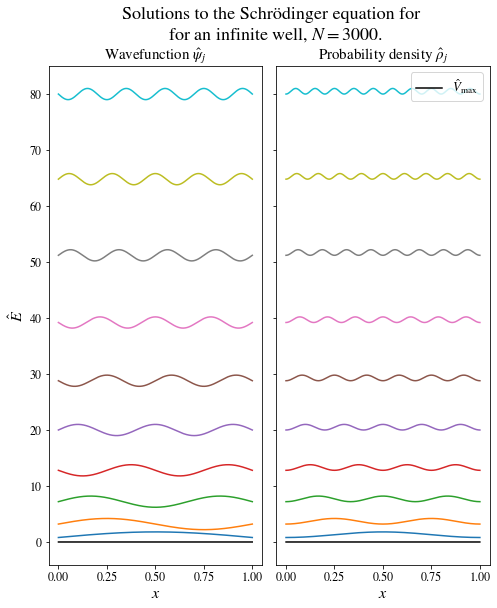

In [33]:
2.2 

# Initialize constants
N = 3000
L = 1
k = 10 # return k first eigenvectors/-values
potential = 'zero'
norm_const = 0.8
norm_amp = get_norm_amp(potential)

# Boundary condition
y0 = 0
yL = 0
condition = 'Dirichlet'

# Establish grid, N inner grid points
dx = L/(N+1)
x, x_full, _ = get_grids(L, N, dx)

# Potential V
V, V_name = get_potential(potential, N, dx)

# Solve eigenvalue problem 
eigvals, eigvects = eigsh(1/dx**2 * sparse_hamilton(N, V, dx), k, which='SM')

# Insert boundary values
eigvects = insert_boundary_eig(eigvects, N, k, y0, yL, condition)
rho = np.power(np.abs(eigvects), 2)

# Normalize and translate solutions
for i in range(len(eigvects)):
    eigvects[i] = norm_amp/np.max(np.abs(eigvects[i])) * eigvects[i] - eigvals[i]/np.min(np.abs(eigvals))*norm_const
    rho[i] = norm_amp/np.max(np.abs(rho[i])) * rho[i] - eigvals[i]/np.min(np.abs(eigvals))*norm_const

# Get potential max for plot
V_max = np.max(np.abs(V))
V_maxs_normed = V_max * np.ones(N)/np.min(np.abs(eigvals))*0.8

### Plot preparation
fig0, ax1 = plt.subplots(1)
fig1, (ax2, ax3) = plt.subplots(ncols=2, sharey=True, figsize=[7, 8], tight_layout=True)

fig1.suptitle(f'Solutions to the Schrödinger equation for \n for a{V_name}, $N=${N}.', fontsize=18, x=0.55, y=1.05)
ax1.plot(x, V)
ax1.set_title('Potential $V(x)$ used in SE', fontsize=15)
ax1.set_xlabel('$x$', fontsize=14)
ax1.set_ylabel('$V(x)$', fontsize=14)

# Plot potential, wavefunctions and probability densities
for i in range(k):
    ax2.plot(x_full, eigvects[k-(i+1)])#, label=r'$\psi$' +  f'$_{i}$')
    ax3.plot(x_full, rho[k-(i+1)])#, label=r'$\psi$' +  f'$_{i}$')
if V_max < np.amax(np.abs(eigvals)):
    ax2.plot(x, V_maxs_normed, label=r'$\hat{V}_{\mathrm{max}}$', color='k')
    ax3.plot(x, V_maxs_normed, label=r'$\hat{V}_{\mathrm{max}}$', color='k')
ax2.set_ylabel('$\hat{E}$', fontsize=16)
ax2.set_xlabel('$x$', fontsize=16)
ax3.set_xlabel('$x$', fontsize=16)
ax2.set_title(r'Wavefunction $\hat{\psi}_j$', fontsize=15)
ax3.set_title(r'Probability density $\hat{\rho}_j$', fontsize=15)
ax3.legend(loc='upper right', fontsize=13)
plt.show()